# Markov Chain Monte Carlo (MCMC) enhanced with Warm-started QAOA

Sampling from complicated distributions is a computationally hard problem. The [paper](https://arxiv.org/abs/2203.12497) introduces a quantum algorithm to perform Markov Chain Monte Carlo (MCMC) to sample from the Boltzmann distribution of classical Ising model. The quantum computing comes into play when proposing a random move at each iteration. It was found that this algorithm converges in fewer iterations (quicker) than common classical MCMC.
- **The problem:** sampling from a Boltzmann distribution of classical Ising models
- The Ising model problem instance is defined as
	- classical Ising model consists of $n$ variables $\left(s_{1}, \ldots, s_{n}\right)=s$ called spins that can take values $s_j = \pm 1$ independently
	- Model instance defined by coefficients $\left\{J_{j k}\right\}_{j>k=1}^{n}$ and $\left\{h_{j}\right\}_{j=1}^{n}$ called couplings and fields, respectively with a temperature $T > 0$ (can be like a graph)
	- Each spin configuration $s \in\{1,-1\}^{n}$ is assigned an energy $$E(s)=-\sum_{j>k=1}^{n} J_{j k} s_{j} s_{k}-\sum_{j=1}^{n} h_{j} s_{j}$$ 
	- and a corresponding Boltzmann probability $\mu (s) = \frac{1}{\mathcal{Z}} e^{-E(s) / T}$ with $\mathcal{Z} = \sum_{s} e^{-E(s) / T}$ ensuring normalisation 
- To compute the values of $E(s)$, computing $\mu(s)$ is required which in turn needs $\mathcal{Z}$ and this partition function could take $\Omega(2^n)$ time to compute.
- On the other hand, MCMC circumvents the computation of $\mu(s)$ and in turn $\mathcal{Z}$ in the following way;
	- the sequential random jumps on each iteration $s \rightarrow s^\prime$ can be carried out with fixed transition probability $P(s^\prime | s)$ - called a *Markov* *Chain* 
	- for the algorithm to be useful these transition probabilities must be carefully chosen to make the process converge to $\mu$, this comprises of two parts;
		- given $s$, propose $s^\prime$ with some probability $Q(s^\prime | s)$ 
		- compute appropriate acceptance probability $A(s^\prime | s)$ based on $Q$ and $\mu$, in this case we will be using the Metropolis-Hastings (M-H) acceptance probability $$A\left(s^{\prime} \mid s\right)=\min \left(1, \frac{\mu\left(s^{\prime}\right)}{\mu(s)} \frac{Q\left(s \mid s^{\prime}\right)}{Q\left(s^{\prime} \mid s\right)}\right)$$
	- $\mu (s)$ and $\mu (s^\prime)$ cannot be efficiently computed, however, M-H acceptance probability depends only on their ratio as $\mathcal{Z}$ cancels out. It is this cancellation that underpins MCMC.
- The choice of strategy when proposing $s^\prime$ for each random jump is the feature of the algorithm which distinguishes the quality of the result for e.g. at low $T$, the rugged landscape makes it difficult to explore the entire region as there is a tendency to be stuck in local minima.
- It is this problem with which a quantum sub-routine will provide an assist.

## Quantum Algorithm
The quantum sub-routine will be used to propose the next step for each iteration and a classical computer will calculate the associated acceptance probability.

Given a current configuration $s$, the computational basis state $|s\rangle$ is prepared. A unitary $U$ is applied which satisfies the symmetry condition $$\left|\left\langle s^{\prime}|U| s\right\rangle\right|=\left|\left\langle s|U| s^{\prime}\right\rangle\right| \text { for all } s, s^{\prime} \in\{-1,1\}^{n}.$$
The output measurement would then give the proposed configuration $s^\prime$.
Computing the acceptance probability $$A\left(s^{\prime} \mid s\right)=\min \left(1, \frac{\mu\left(s^{\prime}\right)}{\mu(s)} \frac{Q\left(s \mid s^{\prime}\right)}{Q\left(s^{\prime} \mid s\right)}\right)$$ becomes easier because $Q\left(s^{\prime} \mid s\right)=\left|\left\langle s^{\prime}|U| s\right\rangle\right|^{2}=Q\left(s \mid s^{\prime}\right)$ and they cancel out in $A\left(s^{\prime} \mid s\right)$. This simplifies the M-H acceptance probability to $$A\left(s^{\prime} \mid s\right)=\min \left(1, e^{-\frac{E\left(s^{\prime}\right)-E(s)}{T}}\right).$$
As in the [paper](https://arxiv.org/abs/2203.12497), the choice of the unitary $U$ is a quantum heuristic. We will explore the results if that choice was a warm-started QAOA.

### Warm-starting QAOA
[Warm-starting QAOA](https://qiskit-community.github.io/qiskit-optimization/tutorials/10_warm_start_qaoa.html) refers to a variation of the QAOA algorithm where an pre-calculated solution is used to increase the likelihood of QAOA converging on better solutions. This can be done by, for e.g. first relaxing a binary Quadratic Program into a continuous problem and using the solution of that relaxed continuous problem to warm-start QAOA on the original problem. This warm-starting comes in the form of altering two aspects of the QAOA algorithm:
1. the Initial State: the QAOA circuit is initialised with a pre-calculated solution i.e. $c^*$. Hence, the initial state changes to $$\left|\phi^{*}\right\rangle=\bigotimes_{i=0}^{n-1} R_{y}\left(\theta_{i}\right)|0\rangle_{n}$$ where $\theta=2 \arcsin \left(\sqrt{c_{i}^{*}}\right)$ 
2. the Mixer Hamiltonian: since the ground state of the mixer must be adjusted for $c^*$, it changes to $$H_{M, i}^{(w s)}=\left(\begin{array}{cc}2 c_{i}^{*}-1 & -2 \sqrt{c_{i}^{*}\left(1-c_{i}^{*}\right)} \\ -2 \sqrt{c_{i}^{*}\left(1-c_{i}^{*}\right)} & 1-2 c_{i}^{*}\end{array}\right)$$ 
In this notebook, both of these are expressed as quantum circuits and added to the QAOA function as parameters (initial_state and mixer, respectively).

*Amna: Missing $\epsilon$ and overlap reasoning with solution state.*

#### Where does this piece fit in the puzzle?
Within each iteration of the MCMC, QAOA is warm started with the previous state $s$, executed, and its output $s^\prime$ considered with the M-H acceptance probability as the following state (if accepted $s\to s^\prime$). 

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
#from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=#insert API-Token here
)

backend = service.backend("ibmq_qasm_simulator")
sampler = Sampler(backend=backend)

## Contents
[Ising Model Problem Instance](#ising)

[Warm-start QAOA](#ws)

[Metropolis-Hastings Acceptance Probability](#mh)

[Run for Fixed Iterations](#run)

[Result](#re)

[Previous Results](#pre)

In [4]:
import numpy as np
import random
import copy
import re
import matplotlib.pyplot as plt

# Problem modelling imports
from docplex.mp.model import Model

# Qiskit imports
from qiskit.circuit import Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit_algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import CplexOptimizer
from qiskit_optimization import QuadraticProgram

from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer

from qiskit.quantum_info import Operator

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

### Ising Model Problem Instance <a id='ising'></a>

In [5]:
qubo_vector = np.array([3.418, 2.0913, 6.2415, 4.4436, 10.892, 3.4051])
qubo_matrix = np.array(
    [
        [1.07978412, 0.00768914, 0.11227606, -0.06842969, -0.01016793, -0.00839765],
        [0.00768914, 0.10922887, -0.03043424, -0.0020045, 0.00670929, 0.0147937],
        [0.11227606, -0.03043424, 0.985353, 0.02307313, -0.05249785, 0.00904119],
        [-0.06842969, -0.0020045, 0.02307313, 0.6043817, 0.03740115, -0.00945322],
        [-0.01016793, 0.00670929, -0.05249785, 0.03740115, 0.79839634, 0.07616951],
        [-0.00839765, 0.0147937, 0.00904119, -0.00945322, 0.07616951, 1.08464544],
    ]
)
n=len(qubo_vector)

quadratic_program = QuadraticProgram('example')

for i in range(6):
        quadratic_program.binary_var(name = 'x_%d' %i)
        
quadratic_program.maximize(quadratic = qubo_matrix, linear = qubo_vector)
print(quadratic_program.export_as_lp_string())

qubo_converter = QuadraticProgramToQubo()
qubo = qubo_converter.convert(quadratic_program)

op, offset = qubo.to_ising()

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: example

Maximize
 obj: 3.418000000000 x_0 + 2.091300000000 x_1 + 6.241500000000 x_2
      + 4.443600000000 x_3 + 10.892000000000 x_4 + 3.405100000000 x_5 + [
      2.159568240000 x_0^2 + 0.030756560000 x_0*x_1 + 0.449104240000 x_0*x_2
      - 0.273718760000 x_0*x_3 - 0.040671720000 x_0*x_4 - 0.033590600000 x_0*x_5
      + 0.218457740000 x_1^2 - 0.121736960000 x_1*x_2 - 0.008018000000 x_1*x_3
      + 0.026837160000 x_1*x_4 + 0.059174800000 x_1*x_5 + 1.970706000000 x_2^2
      + 0.092292520000 x_2*x_3 - 0.209991400000 x_2*x_4 + 0.036164760000 x_2*x_5
      + 1.208763400000 x_3^2 + 0.149604600000 x_3*x_4 - 0.037812880000 x_3*x_5
      + 1.596792680000 x_4^2 + 0.304678040000 x_4*x_5 + 2.169290880000 x_5^2 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



### Warm-start QAOA <a id='ws'></a>

In [6]:
def extract_thetas(initial_state, epsilon):
    thetas = []
    for i in initial_state:
        if i <= epsilon:
            thetas.append(2 * np.arcsin(np.sqrt(epsilon)))
        elif i >= (1-epsilon):
            thetas.append(2 * np.arcsin(np.sqrt(1-epsilon)))
        else:
            thetas.append(2 * np.arcsin(np.sqrt(i)))
    return thetas

def set_init_state(thetas):
    init_qc = QuantumCircuit(len(thetas))
    for idx, theta in enumerate(thetas):
        init_qc.ry(theta, idx)
    return init_qc


In [7]:
def create_mixer_H(thetas):
    circuit = QuantumCircuit(len(thetas))
    beta = Parameter("beta")

    for index, theta in enumerate(thetas):
        circuit.ry(-theta, index)
        circuit.rz(-2.0 * beta, index)
        circuit.ry(theta, index)
    return circuit

def get_WQAOA_circuit(op, initial_state, N = 3):
    thetas = extract_thetas(initial_state, epsilon = 0.3)
    ws_mixer = create_mixer_H(thetas)
    init_qc = set_init_state(thetas)
    ansatz = QAOAAnsatz(op, reps = N, mixer_operator=ws_mixer, initial_state=init_qc)
    param = 2*np.pi*np.random.rand(ansatz.num_parameters)
    ansatz = ansatz.assign_parameters(param)
    return ansatz

def run_WQAOA(qc):
    qc.measure_all()
    qc = generate_preset_pass_manager(optimization_level=1, 
                                      basis_gates=['u', 'cx']).run(qc)
    result = sampler.run(qc).result()
    bin_dict = result.quasi_dists[0].binary_probabilities()
    return bin_dict

def proposed_state(bin_dict_result):
    most_prob_str = max(bin_dict_result, key=bin_dict_result.get)
    s_prime = [int(char) for char in most_prob_str]
    s_prime = s_prime[::-1]
    return s_prime

### Metropolis-Hastings Acceptance Probability <a id='mh'></a>

In [8]:
def metropolis_hastings(s, s_prime, E_s, E_s_prime, T, threshold):
    delta_E = E_s_prime - E_s
    accept_prob = min(1, np.exp(delta_E / T))
    accepted = 0
    if accept_prob >= threshold:
        s = s_prime
        E_s = E_s_prime
        accepted += 1
    return s, E_s, accepted

### Run for Fixed Iterations <a id='run'></a>

In [9]:
# first iteration calculate outside loop to get s & E_s

s = [random.choice([0, 1]) for _ in range(n)]
E_s = abs(qubo.objective.evaluate([int(i) for i in s]))

x = []
y = []
acc_no = 0
iter = 200

# loop starts with second iteration as Metropolis-Hastings (M-H) acceptance probability needs both s AND s_prime
for i in range(iter-1):
    
    circ = get_WQAOA_circuit(op, s)
    
    s_int = int(''.join(map(str, s)), 2)
    x.append(s_int)
    y.append(E_s)
    
    result = run_WQAOA(circ)
    
    s_prime = proposed_state(result)
    E_s_prime = abs(qubo.objective.evaluate([int(i) for i in s_prime]))
    
    accept_threshold = np.random.uniform(0, 1)
    
    T = 5
    s, E_s, accepted = metropolis_hastings(s, s_prime, E_s, E_s_prime, T, accept_threshold)
    
    acc_no = acc_no + accepted
    
accept_rate = acc_no / iter


### Result <a id='re'></a>

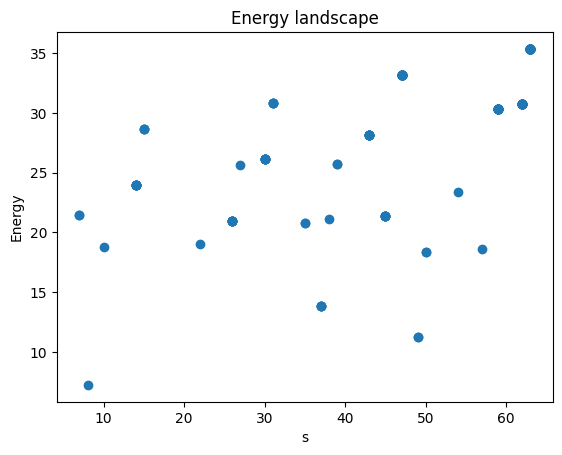

0.225


In [10]:
plt.scatter(x, y) # where i is simply the iterator
plt.xlabel("s")
plt.ylabel("Energy")
plt.title("Energy landscape")

plt.show()
print(accept_rate)

In [11]:
print("The QMCMC solution (successive convergence to) is " + str(y))

The QMCMC solution (successive convergence to) is [18.397170329999998, 18.397170329999998, 26.130253869999997, 26.130253869999997, 26.130253869999997, 21.378583900000002, 21.378583900000002, 21.378583900000002, 26.130253869999997, 26.130253869999997, 23.9811839, 23.9811839, 23.9811839, 23.9811839, 23.9811839, 20.96533261, 20.96533261, 21.43635836, 21.43635836, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 30.71077315, 25.655086850000004, 23.9811839, 23.9811839, 30.355670210000003, 30.355670210000003, 30.355670210000003, 30.355670210000003, 30.355670210000003, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000000004, 33.170790000

### Previous Results <a id='pre'></a>

For $T = 5$, $200$ iterations on a known $6 \times 6$ problem with $E$ having absolute value, we get 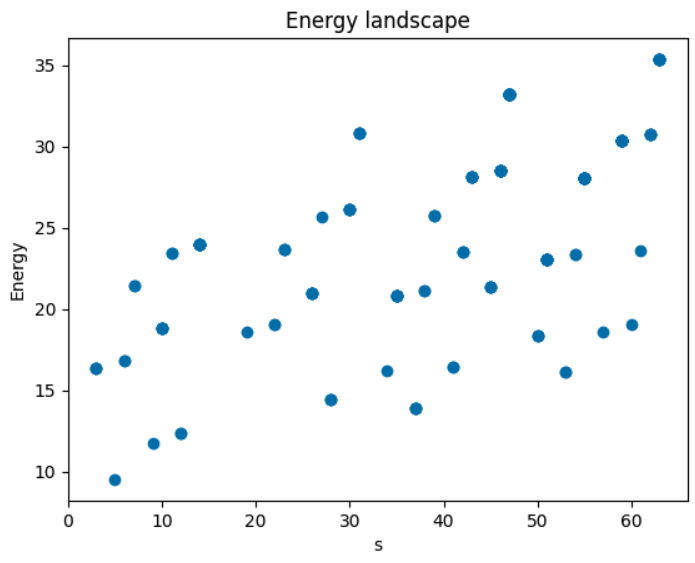 with an acceptance rate $0.36$

For $T = 5$, $200$ iterations on a $8 \times 8$ problem with $E$ having absolute value, we get 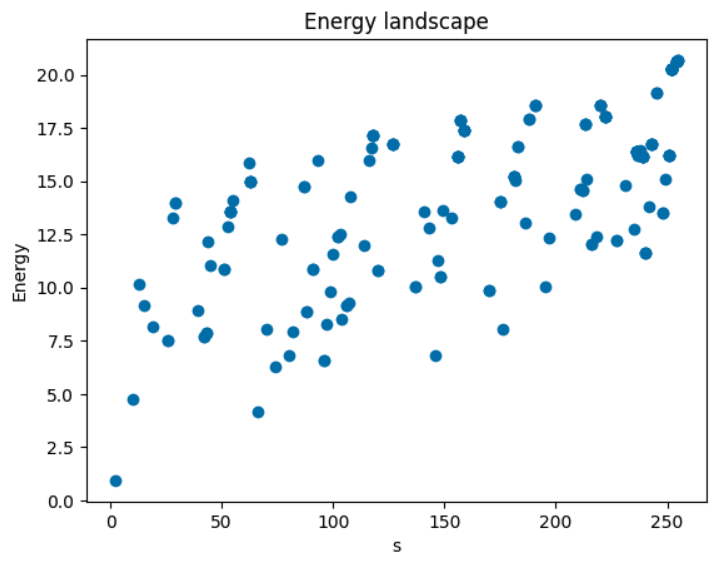 with an acceptance rate $0.62$

For $T = 10$, $200$ iterations on a $8 \times 8$ problem we get 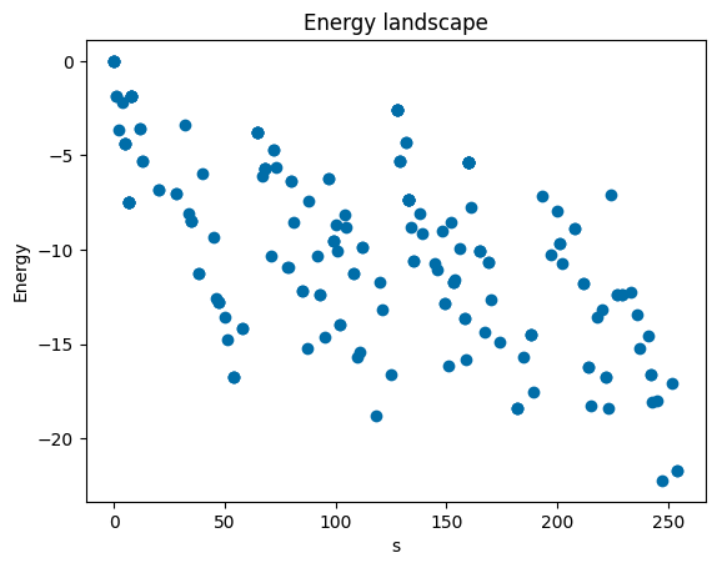 with an acceptance rate $\approx 0.9$

For $T = 5$, $200$ iterations on a $8 \times 8$ problem we get 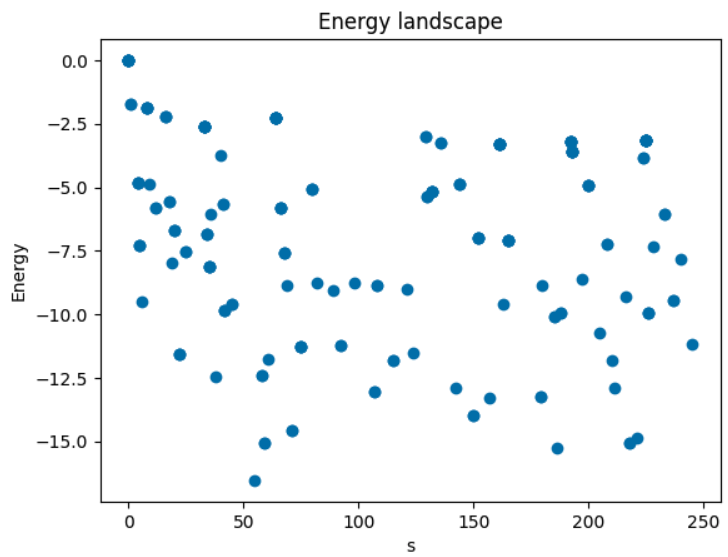
with an acceptance rate $0.56$

For $T = 1$, $200$ iterations on a $8 \times 8$ problem we get 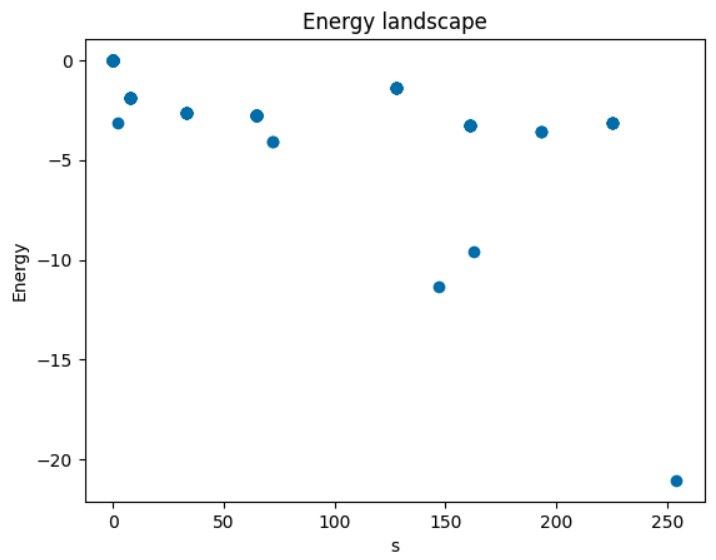
with an acceptance rate $0.09$